#### Ladda data och definiera variabler

In [158]:
#encoding: utf8
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import interactive as intr
import visualize as vis
import danframe as dan
import kontin as con
import lines as lin
import numpy as np



s6405_t5p = dan.frameseries("data/6405_aS1","top 5%")
s6405_seg = dan.frameseries("data/6405_aS1","segments")

lins = lin.make_lines_from_wins(s6405_t5p,s6405_t5p.pkwindows)

FeI  = lins[1]
SiFe = lins[2]
myst = lins[3]

mes = {}
mes["FeI top 5%"]  = FeI.measure_linecores(s6405_t5p)
mes["FeI segm"  ]  = FeI.measure_linecores(s6405_seg)
mes["Myst top 5%"] = myst.measure_linecores(s6405_t5p)
mes["Myst segm"  ] = myst.measure_linecores(s6405_seg)

Myst_t5_cont = mes["Myst top 5%"][slice(lin.lc.cont,63,3),1:-1].reshape((-1))
Myst_t5_lcen = mes["Myst top 5%"][slice(lin.lc.lbot,63,3),1:-1].reshape((-1))

mes["FeI top 5% by line"]  = FeI.byline_measure_linecores(s6405_t5p)
mes["Myst top 5% by line"] = myst.measure_linecores(s6405_t5p)


#Konstiga mätningar
# Första bilden
# Myst segm   : 10,406,693, (695)
# Myst top 5% : 10,406,693, (695)

# 406,693,695 - ett extremvärde vid randen

### Examining scatter of line bottom
Plotting the relative line intensity at line bottom versus the continuum value (as given by the linear continuum fit) at line centre we see clear clustering but with some suspicious values for the outliers: negative intensities as well as relative intensities larger that one...

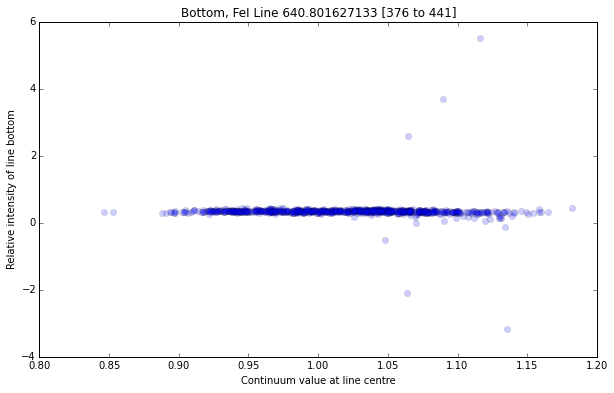

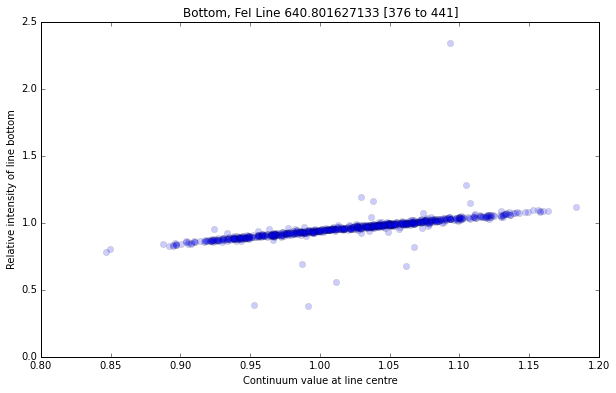

In [202]:
%matplotlib inline
pl.rcParams["figure.figsize"] = (10,6) # Bigger figures

pl.plot(mes["FeI top 5%"][lin.lc.cont,:],mes["FeI top 5%"][lin.lc.lbot,:],'bo',alpha=0.2);
pl.title("Bottom, FeI " + str(FeI))
pl.ylabel("Relative intensity of line bottom")
pl.xlabel("Continuum value at line centre")
pl.show()

### Manually checking the fit on one of the outlier fits
Choosing one of the outliers with negative relative line intensity, specifically the one from row 313.

First load the data

In [279]:
%matplotlib inline
pl.rcParams["figure.figsize"] = (10,6) # Bigger figures
frm     = s6405_t5p.frames[0]; 
ref,lmd = frm.group.ref,frm.group.lmbd
s313  = frm.spec(313) # The frame row that gives the outlier

The method for identifying the line bottom is very simple: take the minimal value (of the reference spectra in the line window) as the guess of the central value. Then use that and four points to either side to fit a second order polynomial with the least squres method.

Doing this using the same FeI line as shown in the scatter plot above, using one of the outliers, results in the plot below; the blue line is the spectra, the red: the fit, the black stars are the point that the method outlined above has selected as the bottom of the line.

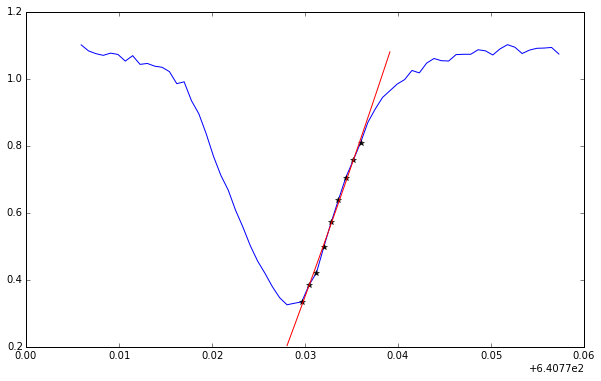

In [280]:
guess  = frm.group.ref[FeI.idx].argmin()
bottom = FeI.idx[slice(guess-4,guess+5)]
a,b,c  = np.polyfit(lmd[bottom],s313[bottom],2)
fit    = np.polyval((a,b,c),lmd[FeI.idx])

pl.plot(lmd[FeI.idx],s313[FeI.idx],'b')
pl.plot(lmd[bottom],s313[bottom],'*k')
pl.plot(lmd[FeI.idx[23:38]],fit[23:38],'r')

pl.show()

It is clear that the above simple procedure for identifying the line bottom does not handle when the line centre shifts too far away from its position in the reference spectra.

A better method would examine each row of a frame individually, finding the minimum at each row and taking the neighbourhood of that as the line bottom on which to perform the fit. The result of this method on the same line as above is shown below 

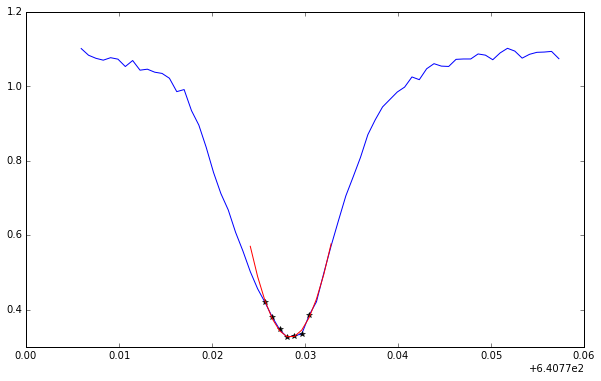

In [281]:
bottom = select_bottom(FeI,s313)
a,b,c  = np.polyfit(lmd[bottom],s313[bottom],2)
fit    = np.polyval((a,b,c),lmd[FeI.idx])

pl.plot(lmd[FeI.idx],s313[FeI.idx],'b')
pl.plot(lmd[bottom],s313[bottom],'*k')
pl.plot(lmd[FeI.idx[31:43]],fit[31:43],'r')

pl.show()

Employing this method on the entire frame used for the scatter plot shown above significantly improves the most extreme scatter:

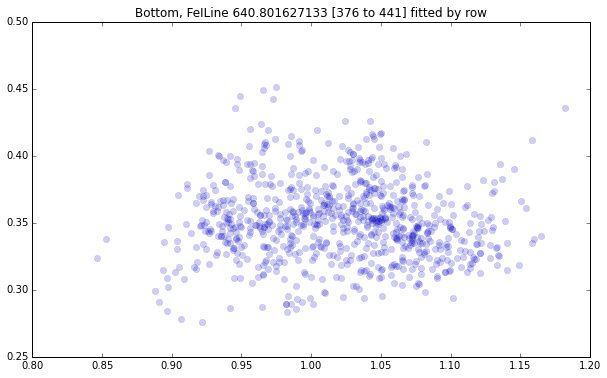

In [197]:
pl.plot(mes["FeI top 5% by line"][lin.lc.cont,:-1],mes["FeI top 5% by line"][lin.lc.lbot,:-1],'bo',alpha=0.2);
pl.title("Bottom, FeI" + str(FeI) + " fitted by row")
pl.show()

#### The largest outlier of the unknown line
Investigating one of the outliers of the unknown line that remains after using the improved method. It seems like this line requires smoothing before a fit can meaningfully be applied, in contrast to the line above. 

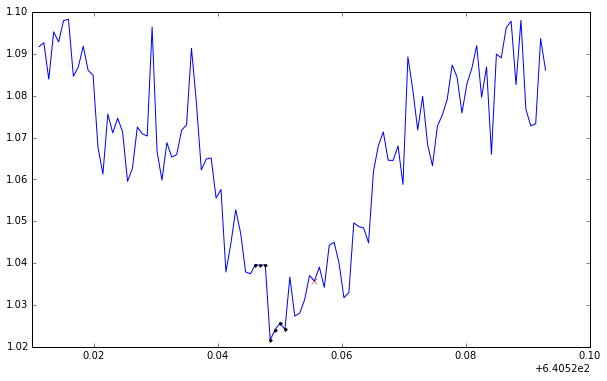

In [284]:
%matplotlib inline
pl.rcParams["figure.figsize"] = (10,6) # Bigger figures
frm  = s6405_t5p.frames[0]
spe  = frm.spec(10) # Outlier
ref  = frm.group.ref
lmd  = frm.group.lmbd
ln   = myst
guess = frm.group.ref[ln.idx].argmin()
bottom  = select_bottom(ln,spe,3)


pl.plot(lmd[ln.idx],spe[ln.idx],'b')
pl.plot(lmd[bottom],spe[bottom],'.k')
pl.plot(lmd[ln.idx[guess]],spe[ln.idx[guess]],'xr')
pl.show()


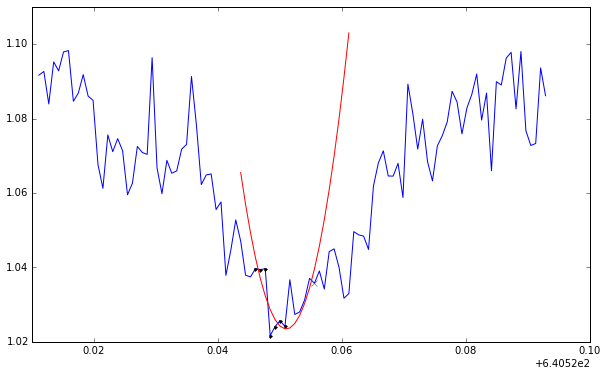

In [285]:

a,b,c   = np.polyfit(lmd[bottom],spe[bottom],2)
lam_min = -b/(2*a)
lin_bot = np.polyval((a,b,c),lam_min)
fit = np.polyval((a,b,c),lmd[ln.idx])


pl.plot(lmd[ln.idx],spe[ln.idx],'b')
pl.plot(lmd[bottom],spe[bottom],'.k')
pl.plot(lmd[ln.idx[40:63]],fit[40:63],'r')
pl.plot(lmd[ln.idx[guess]],spe[ln.idx[guess]],'xg')
pl.show()


Some more examples of the unkonwn line

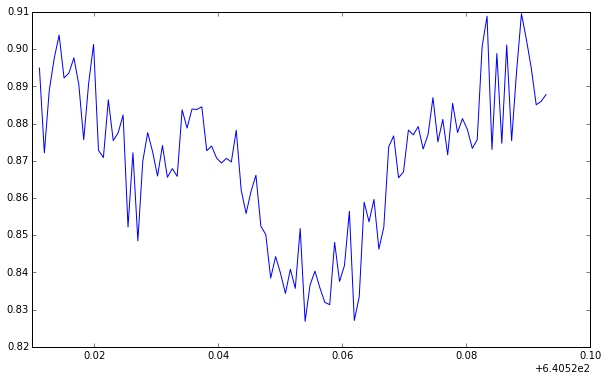

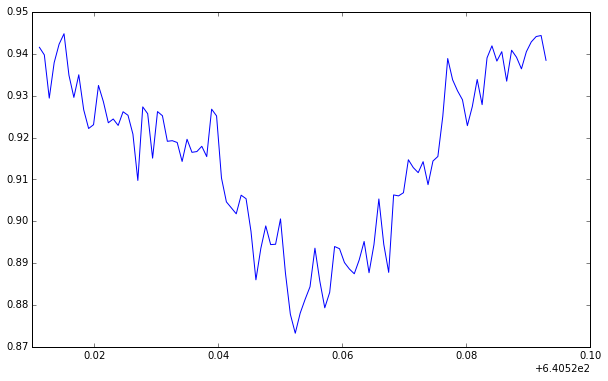

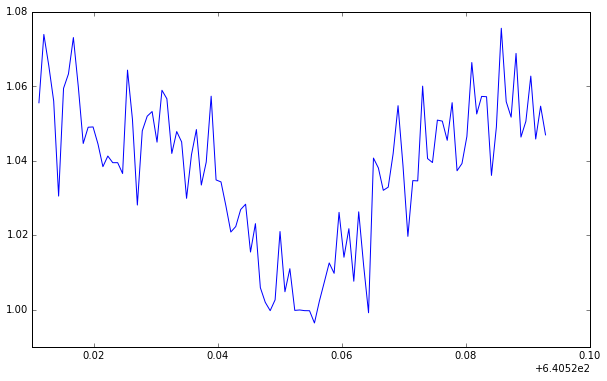

In [286]:
spe  = frm.spec(431) # Outlier
guess = frm.group.ref[ln.idx].argmin()
bottom  = select_bottom(ln,spe,3)
pl.plot(lmd[ln.idx],spe[ln.idx],'b')
pl.show()

spe  = frm.spec(701) # Outlier
guess = frm.group.ref[ln.idx].argmin()
bottom  = select_bottom(ln,spe,3)
pl.plot(lmd[ln.idx],spe[ln.idx],'b')
pl.show()

spe  = frm.spec(211) # Outlier
guess = frm.group.ref[ln.idx].argmin()
bottom  = select_bottom(ln,spe,3)
pl.plot(lmd[ln.idx],spe[ln.idx],'b')
pl.show()

In [241]:
def select_bottom(line,spectra,width=3):
    cent = spectra[line.idx].argmin()
    return line.idx[cent+np.arange(-width,width+1)]

In [273]:
%matplotlib qt
intr.select_linecore(mes["Myst top 5% by line"])

[695] [ 0.99124476] [ 0.38278462]
[406] [ 0.95313555] [ 0.38588662]
[693] [ 1.01189805] [ 0.55829083]
[10] [ 1.09301962] [ 2.34411896]
[259] [ 1.0614651] [ 0.67775056]
[316] [ 1.0674113] [ 0.81786686]
[0] [ 1.10504831] [ 1.283212]
[742] [ 1.02917075] [ 1.19614731]
[318] [ 1.03839462] [ 1.15973628]
[693] [ 1.01189805] [ 639.36866973]
[695] [ 0.99124476] [ 640.2253715]
[406] [ 0.95313555] [ 641.04553637]
[10] [ 1.09301962] [ 641.55558709]
[10]